In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import json
import os
from collections import defaultdict

import rasterio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

from geospatial.visualization.raster_label_visualizer import RasterLabelVisualizer

# Evaluation against 2019-2020/04 verified labels

WCS Colombia corrected the coarse category model's output in seven randomly selected windows. Here we evaluate the model's outputs (different versions: after applying a majority filter) against these labels.

Note that when the manual correction was carried out, most sandy area near rivers were eliminated even if sandy areas are visible from the 2019-2020 Landsat8 composite image.

The verified polygons are first rasterized using GDAL. The rasterized versions are in the `labels_dir` directory specified below.

### Micro and macro averages

The "micro" averages are metrics calculated globally by counting the total true positives, false negatives and false positives.

The "macro" averages are the unweighted mean across each label, for the metrics calculated for each label.

We do not use a weighting among the categories, so the "weighted" average is the same as the "micro" average.

In [3]:
labels_dir = '/Users/siyuyang/Data/WCSColombia/provided_labels/Landuse_corrections_Felipe/results_corrected_raster'

# raw output
model_outputs_raw_path = '/Users/siyuyang/Data/WCSColombia/delivered/20201221_timepoints/2019_202004/res_wcs_orinoquia_sr_median_2019_202004.vrt'

# majority filter radius 3
model_outputs_filtered3_path = '/Users/siyuyang/Data/WCSColombia/delivered/20200715/results_coarse_baseline_201920_filtered3/po_res_wcs_orinoquia_sr_median_2019_202004.vrt'

model_outputs_filtered5_path = '/Users/siyuyang/Data/WCSColombia/delivered/20200715/results_coarse_baseline_201920_filtered5/po_res_wcs_orinoquia_sr_median_2019_202004.vrt'

model_outputs_filtered7_path = '/Users/siyuyang/Data/WCSColombia/delivered/20200715/results_coarse_baseline_201920_filtered7/po_res_wcs_orinoquia_sr_median_2019_202004.vrt'

In [4]:
viz = RasterLabelVisualizer('../constants/class_lists/wcs_coarse_label_map.json')

In [5]:
with open('../constants/class_lists/wcs_coarse_label_map.json') as f:
    label_map = json.load(f)

In [6]:
# for the classification reports
labels = [int(i) for i in label_map['num_to_name'].keys() if i not in ['0', '9']]  # exclude "Empty of data" and label "Unavailable" categories
target_names = [label_map['num_to_name'][str(i)] for i in labels]

In [23]:
def evaluate_label_windows(model_outputs_path, visualize=True, return_tiles=False):

    results = {}
    
    model_outputs_reader = rasterio.open(model_outputs_path)

    # for overall across all tiles
    y_true = []
    y_pred = []

    for label_f in tqdm(os.listdir(labels_dir)):
        if not label_f.endswith('.tif'):
            continue

        window_name = label_f.split('.tif')[0]
        results[window_name] = {}

        label_tile_reader = rasterio.open(os.path.join(labels_dir, label_f))

        # get the window to crop the corresponding scene from the big (vrt) model outputs raster
        x_min = label_tile_reader.bounds.left
        y_min = label_tile_reader.bounds.top  # origin is left, top

        # getting the pixel array indices corresponding to points in georeferenced space
        row, col = model_outputs_reader.index(x_min, y_min)

        row_end = row + label_tile_reader.height  # both rasters have the same resolution
        col_end = col + label_tile_reader.width 

        w = rasterio.windows.Window.from_slices((row, row_end), (col, col_end))

        model_output_tile = model_outputs_reader.read(1, window=w)
        label_tile = label_tile_reader.read(1)

        if visualize:
            im, buf = viz.show_label_raster(model_output_tile, (12, 7))
            results[window_name]['model_output_tile'] = im
            im, buf = viz.show_label_raster(label_tile, (12, 7))
            results[window_name]['label_tile'] = im

        assert model_output_tile.shape == label_tile.shape
        report = classification_report(label_tile.flatten(), model_output_tile.flatten(),
                                       labels=labels, target_names=target_names,
                                       zero_division=0, digits=3)
        results[window_name]['report'] = report
        
        window_y_true = label_tile.flatten()
        window_y_pred = model_output_tile.flatten()
        
        results[window_name]['cm'] = confusion_matrix(window_y_true, window_y_pred, labels=labels)
        results[window_name]['cm_norm'] = confusion_matrix(window_y_true, window_y_pred, labels=labels, 
                                                           normalize='true')  # normalize over the true counts
        
        y_true.extend(window_y_true)
        y_pred.extend(window_y_pred)

    print('Calculating overall metrics...')
    overall_report = classification_report(y_true, y_pred, labels=labels, target_names=target_names, digits=3)
    
    if return_tiles:
        return results, overall_report, y_true, y_pred
    
    return results, overall_report

In [40]:
def plot_confusion_matrix(cm, label_names, dpi=150):
    # docs: https://matplotlib.org/3.1.3/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py

    num_classes = len(label_names)
    assert cm.shape[0] == num_classes
    
    fig = plt.figure(figsize=(10, 10), dpi=dpi)  # set dpi to 300 to look good
    ax = fig.add_axes([0.0, 0.0, 1.0, 1.0])
    im = ax.matshow(cm, cmap=plt.cm.YlGnBu)
    _ = ax.set_xticks(np.array(range(num_classes)))
    _ = ax.set_yticks(np.array(range(num_classes)))
    _ = ax.set_xticklabels(label_names)
    _ = ax.set_yticklabels(label_names)
    _ = ax.set_ylabel('Actual label')
    _ = ax.set_xlabel('Predicted by model')
    _ = ax.xaxis.tick_top()

    # Rotate the tick labels
    _ = plt.setp(ax.get_xticklabels(), rotation=90)

    _ = ax.set_xticks(np.array(range(num_classes)) - 0.5, minor=True)
    _ = ax.set_yticks(np.array(range(num_classes)) - 0.5, minor=True)
    _ = ax.grid(which='minor', color='white', linestyle='-', linewidth=3)

    cbar = ax.figure.colorbar(im, ax=ax)

    # no border
    for edge, spine in ax.spines.items():
            _ = spine.set_visible(False)
    
    plt.close()  # to not show all figures plotted again at the end of the calling cell
    return fig

## Evaluating model outputs (raw)

No filtering

In [20]:
results, overall_report, y_true, y_pred = evaluate_label_windows(model_outputs_raw_path, return_tiles=True)

100%|██████████| 7/7 [00:40<00:00,  5.82s/it]


Calculating overall metrics...


Evaluating window_1
Model output:


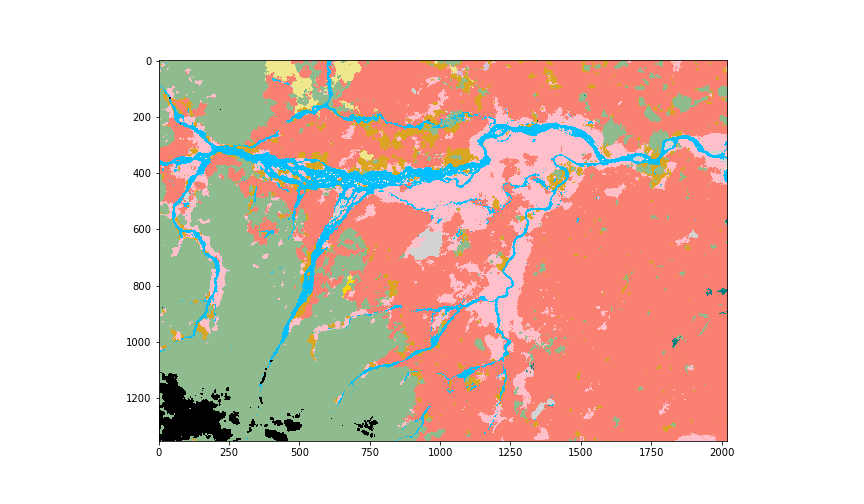

Labels after correction:


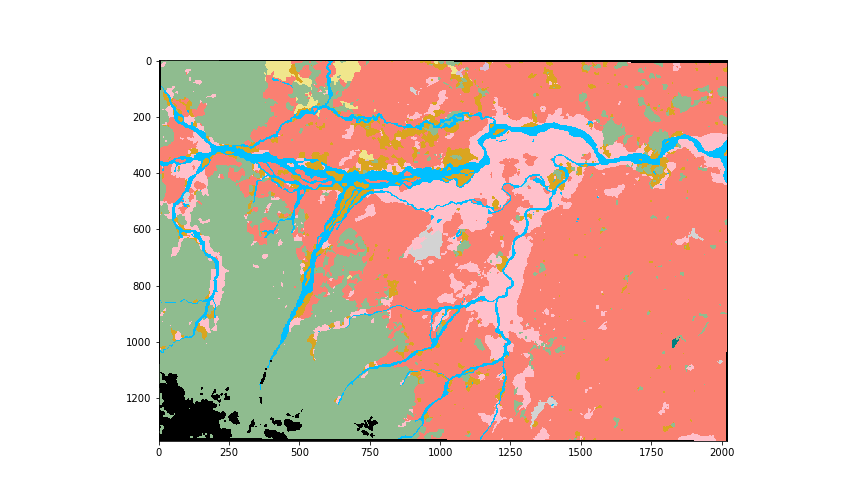

                             precision    recall  f1-score   support

   Urban and infrastructure      0.614     0.807     0.697     13276
                Agriculture      0.888     0.929     0.908    298257
Arboreal and forestry crops      0.242     0.921     0.383       504
                    Pasture      0.968     0.969     0.969   1364995
                 Vegetation      0.824     0.743     0.781    115579
                     Forest      0.961     0.977     0.969    689297
                    Savanna      0.000     0.000     0.000         0
  Sand, rocks and bare land      0.000     0.000     0.000         0
                      Swamp      0.000     0.000     0.000         0
                      Water      0.838     0.850     0.844    153843
           Seasonal savanna      0.749     0.926     0.828     16833
 Seasonally flooded savanna      0.651     0.783     0.711      1213

                  micro avg      0.938     0.948     0.943   2653797
                  macro avg     

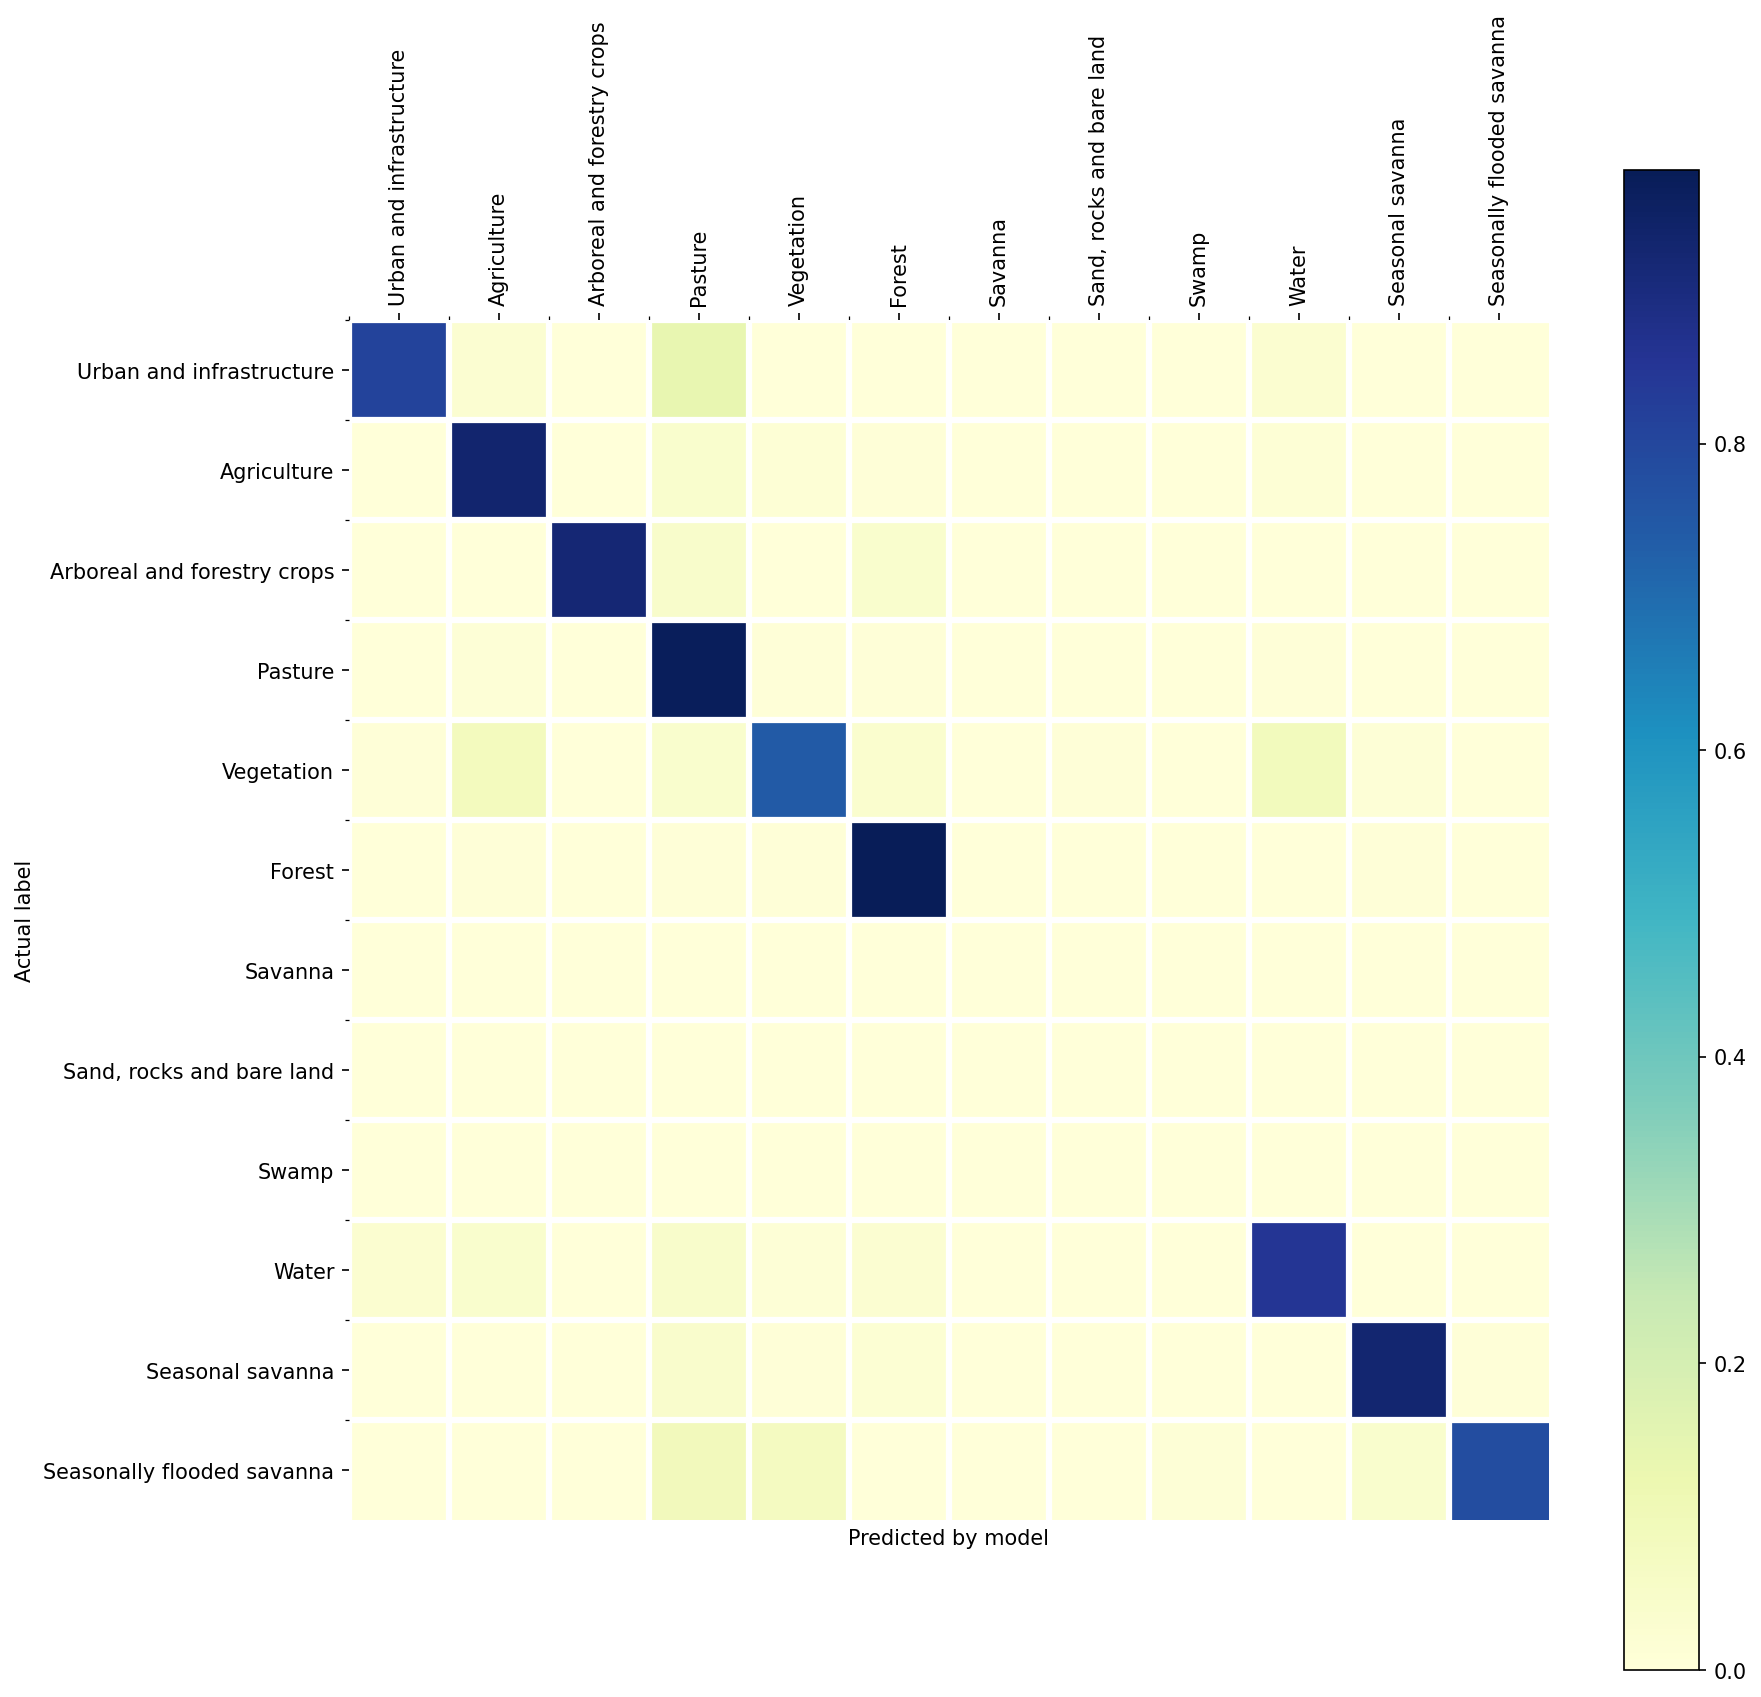

-------------------------------------------------------------------------------


Evaluating window_3
Model output:


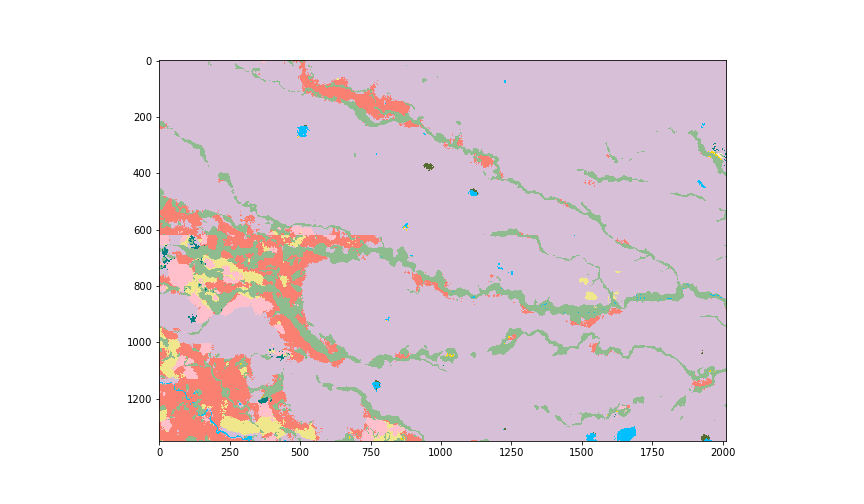

Labels after correction:


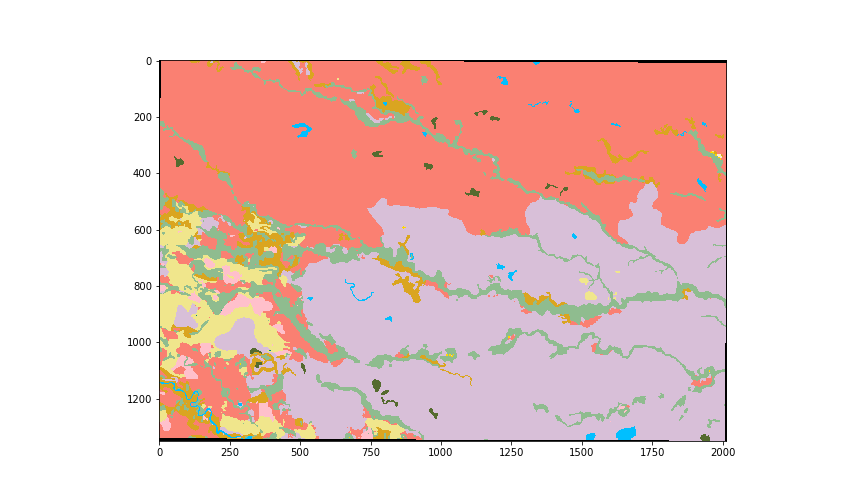

                             precision    recall  f1-score   support

   Urban and infrastructure      0.000     0.000     0.000         0
                Agriculture      0.501     0.913     0.647     26137
Arboreal and forestry crops      0.010     0.633     0.020        60
                    Pasture      0.685     0.121     0.206   1166879
                 Vegetation      0.766     0.001     0.002     91744
                     Forest      0.937     0.889     0.912    241676
                    Savanna      0.462     0.790     0.583       591
  Sand, rocks and bare land      0.751     0.819     0.784       188
                      Swamp      0.787     0.128     0.220      9342
                      Water      0.657     0.491     0.562     13413
           Seasonal savanna      0.817     0.336     0.476    105051
 Seasonally flooded savanna      0.470     0.989     0.637   1035476

                  micro avg      0.532     0.538     0.535   2690557
                  macro avg     

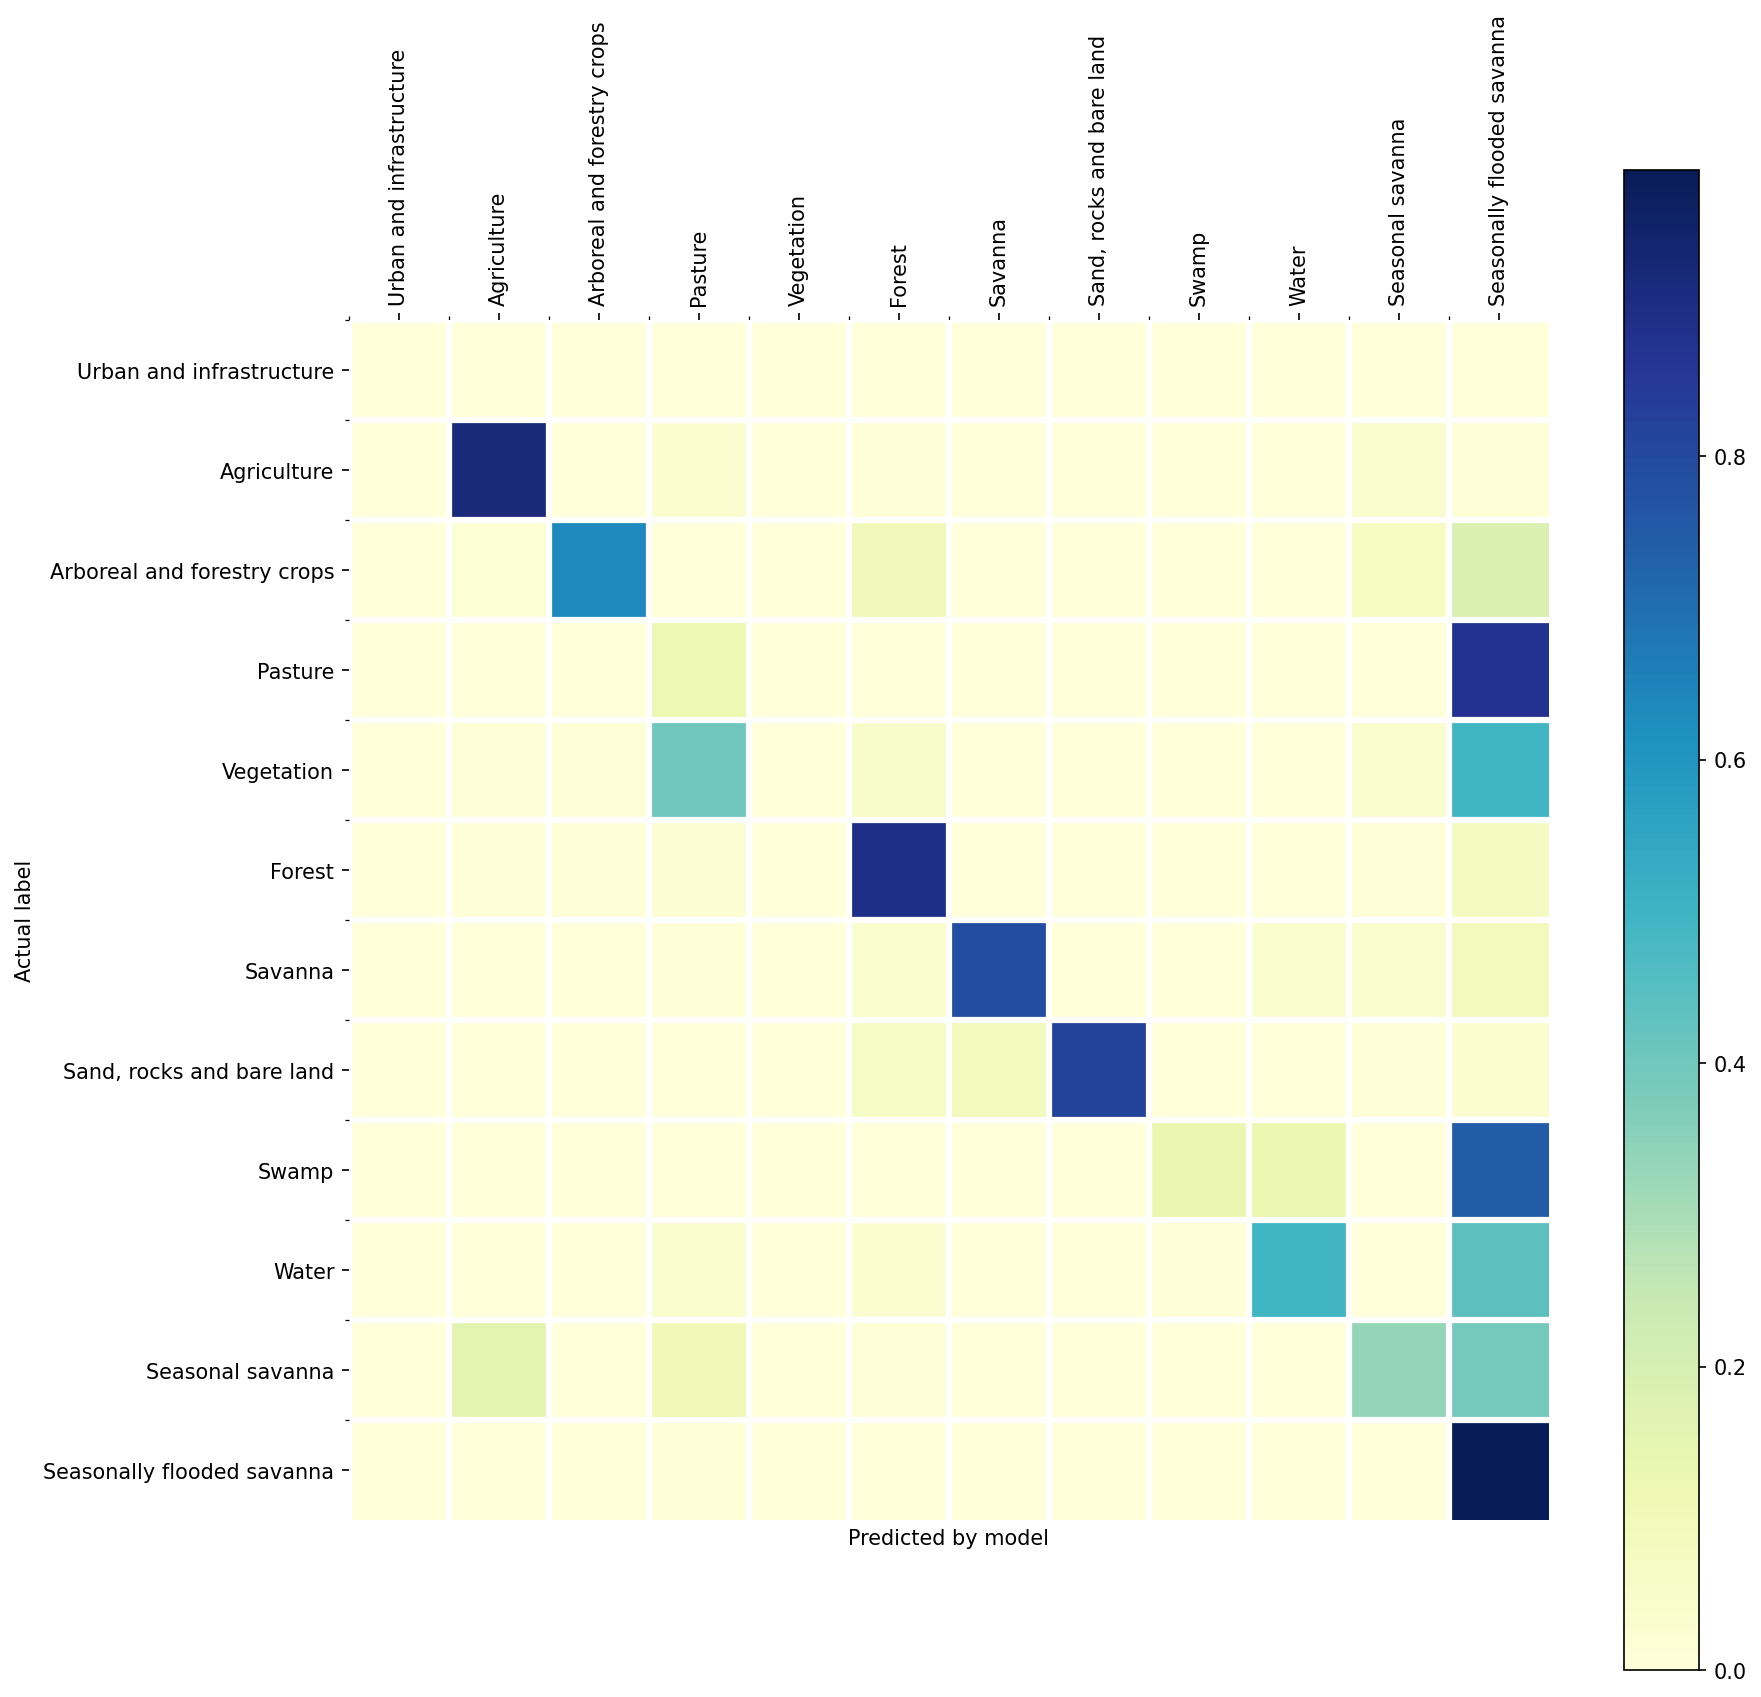

-------------------------------------------------------------------------------


Evaluating window_7
Model output:


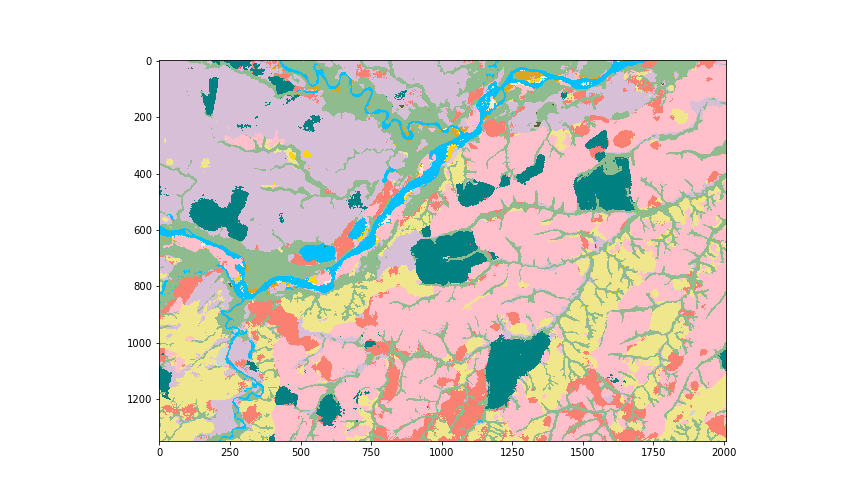

Labels after correction:


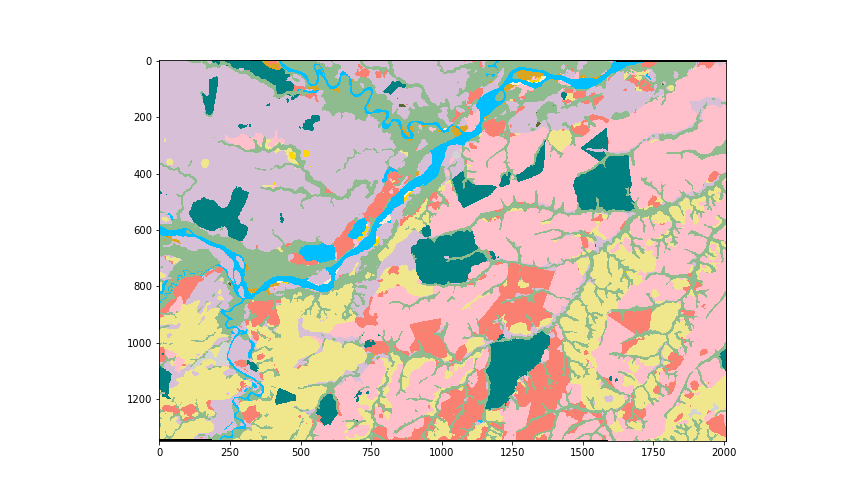

                             precision    recall  f1-score   support

   Urban and infrastructure      0.930     0.437     0.595      6102
                Agriculture      0.776     0.931     0.846    658161
Arboreal and forestry crops      0.921     0.900     0.910    180212
                    Pasture      0.658     0.544     0.596    229599
                 Vegetation      0.770     0.740     0.755     10096
                     Forest      0.918     0.924     0.921    491817
                    Savanna      0.411     0.818     0.547      3076
  Sand, rocks and bare land      0.323     0.748     0.451      2374
                      Swamp      0.690     0.615     0.651       637
                      Water      0.899     0.899     0.899     91188
           Seasonal savanna      0.818     0.718     0.765    421437
 Seasonally flooded savanna      0.930     0.895     0.912    593648

                  micro avg      0.844     0.850     0.847   2688347
                  macro avg     

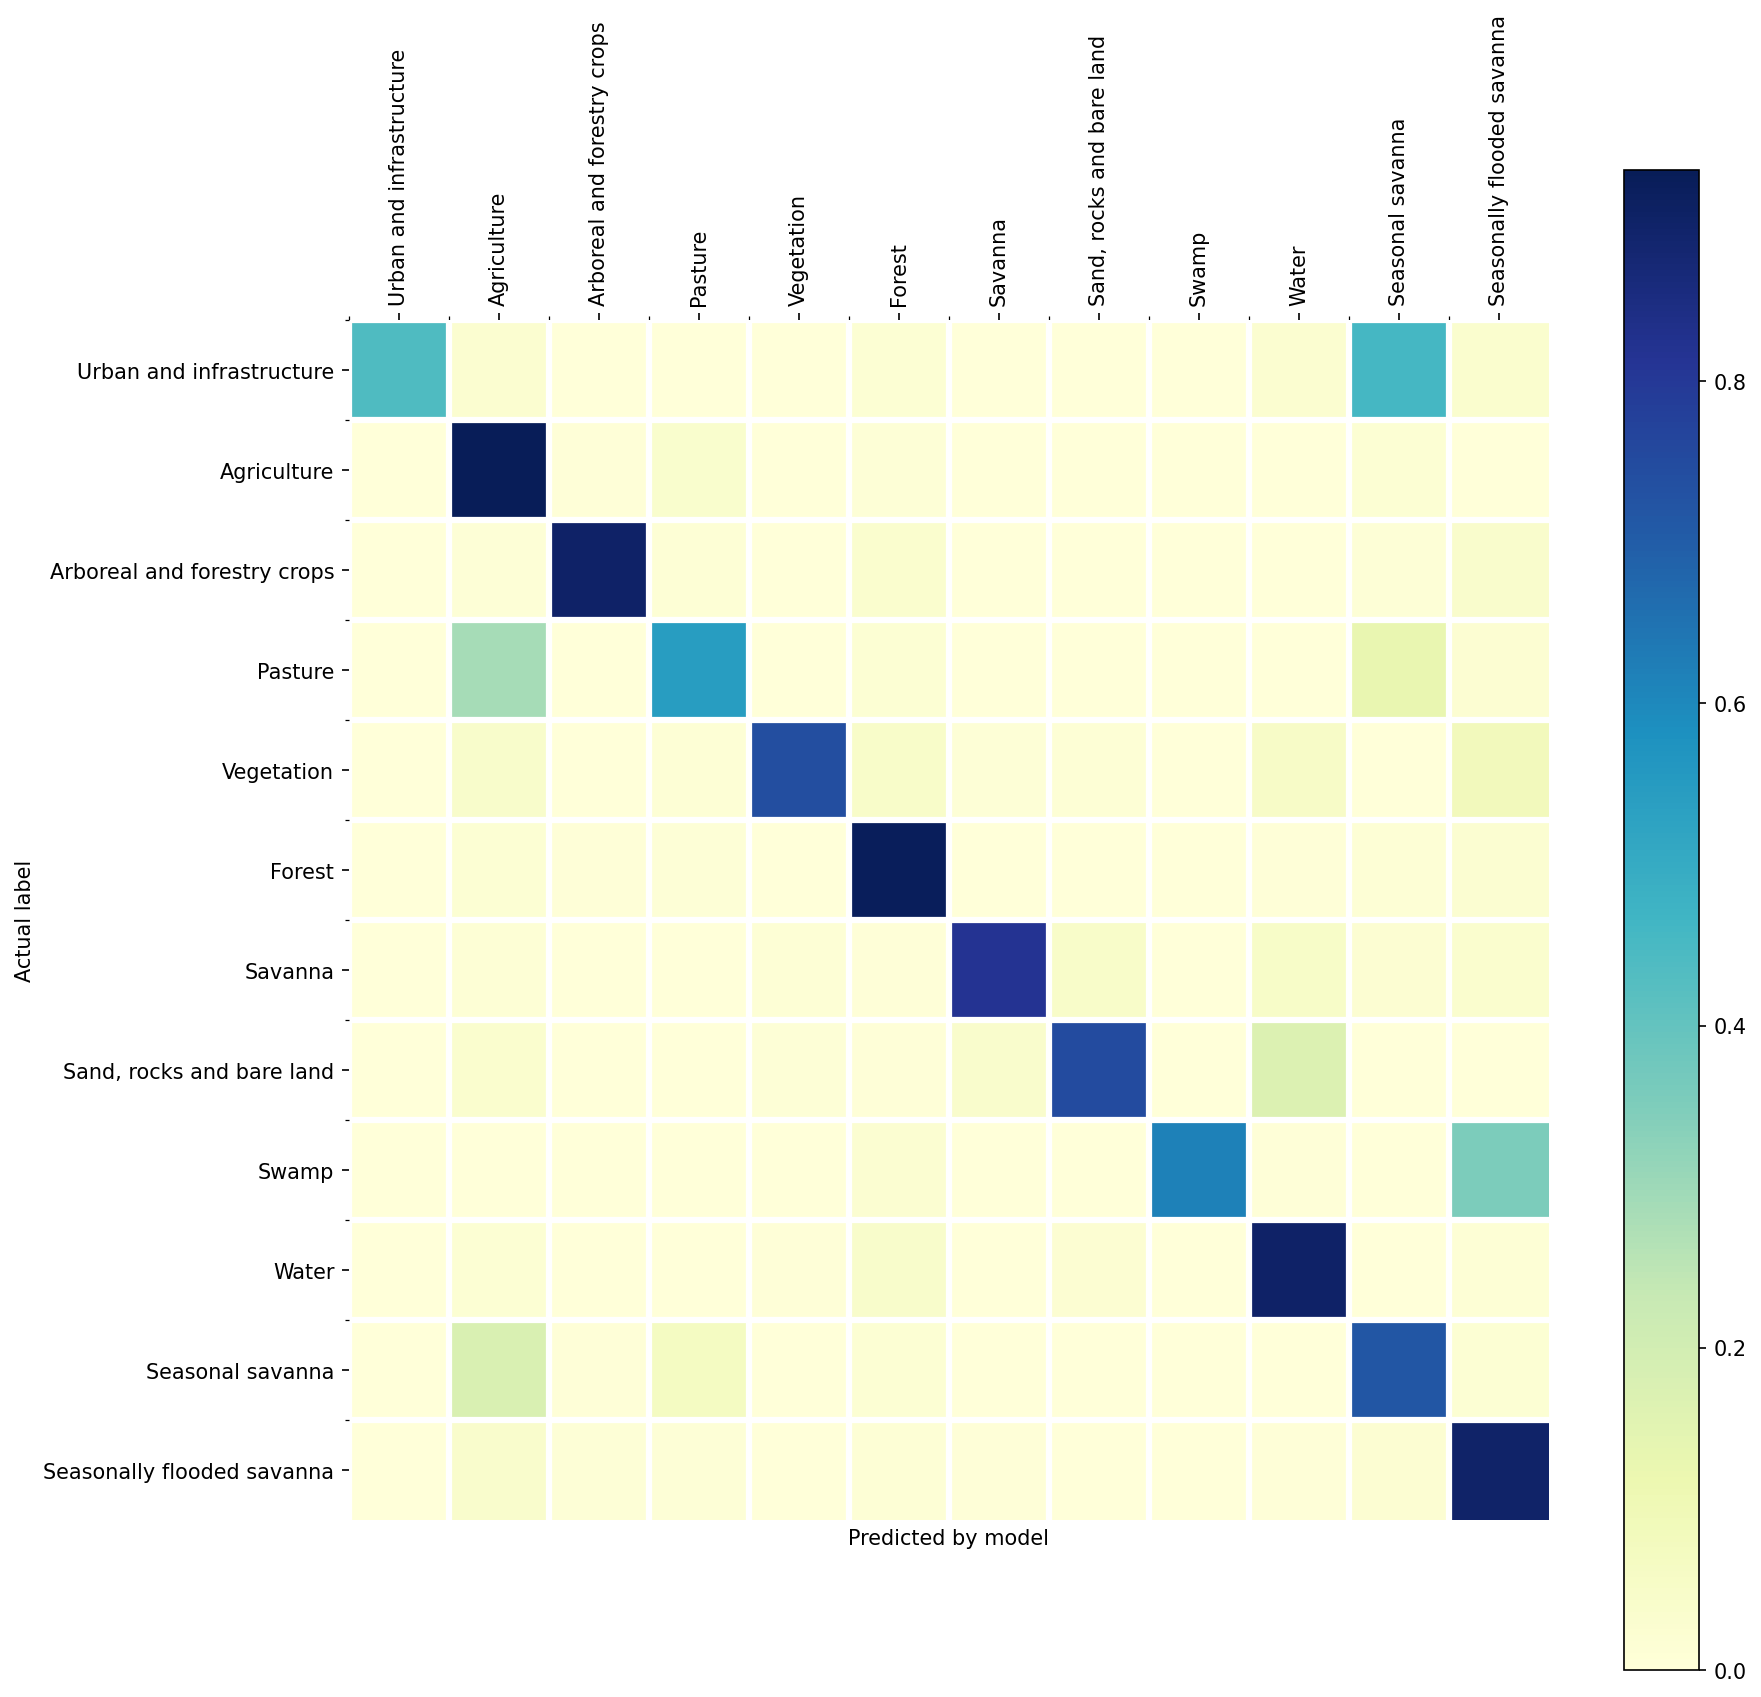

-------------------------------------------------------------------------------


Evaluating window_5
Model output:


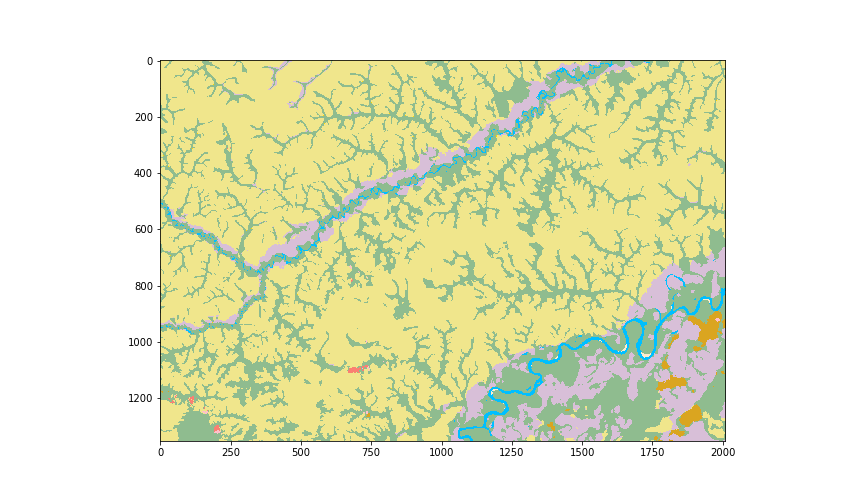

Labels after correction:


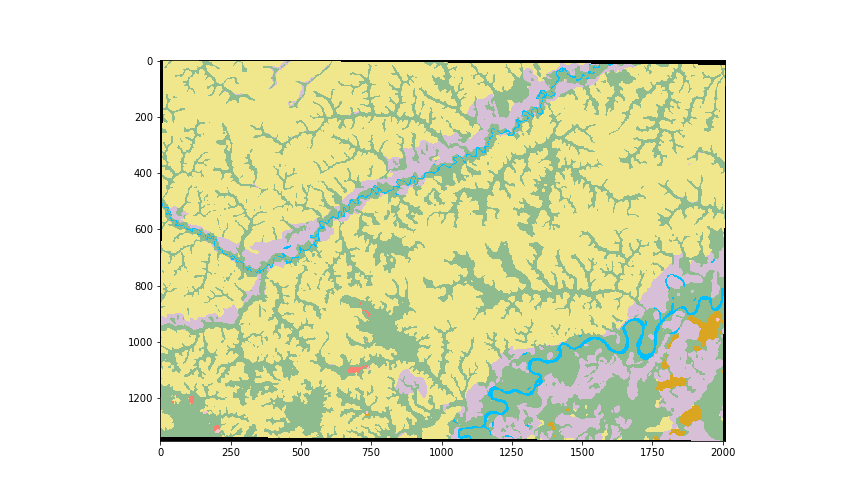

                             precision    recall  f1-score   support

   Urban and infrastructure      0.000     0.000     0.000         0
                Agriculture      0.649     0.811     0.721       904
Arboreal and forestry crops      0.000     0.000     0.000         0
                    Pasture      0.831     0.720     0.771      2401
                 Vegetation      0.931     0.948     0.939     18131
                     Forest      0.915     0.859     0.886    785706
                    Savanna      0.014     0.857     0.028         7
  Sand, rocks and bare land      0.003     1.000     0.005         3
                      Swamp      0.000     0.000     0.000         0
                      Water      0.853     0.788     0.819     36741
           Seasonal savanna      0.900     0.977     0.937   1562505
 Seasonally flooded savanna      0.930     0.803     0.862    264971

                  micro avg      0.906     0.922     0.914   2671369
                  macro avg     

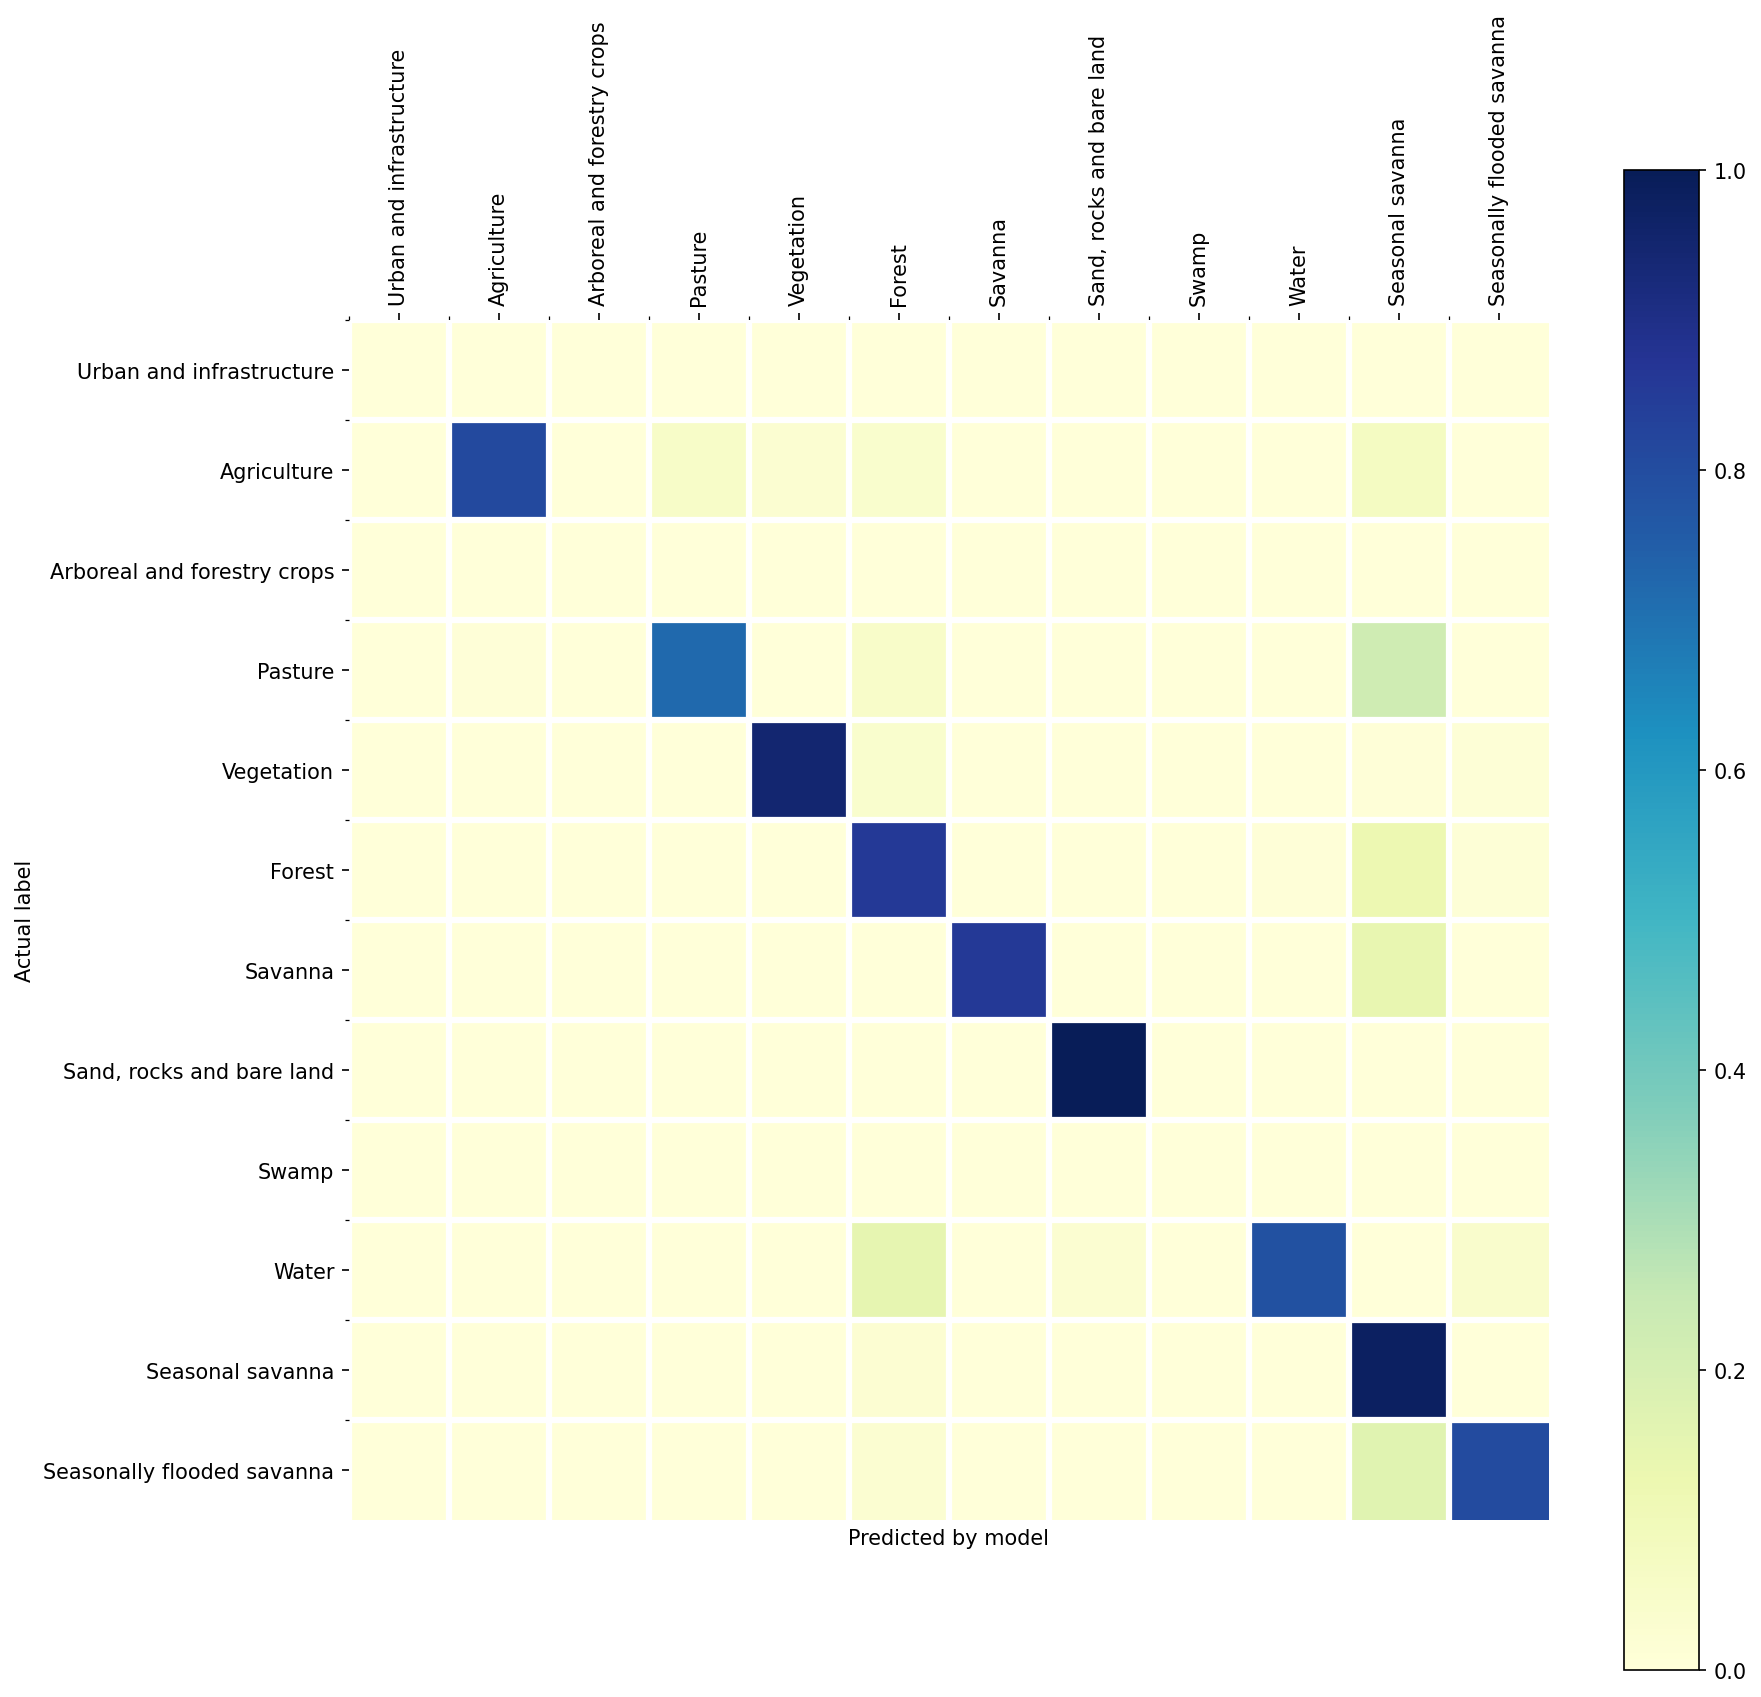

-------------------------------------------------------------------------------


Evaluating window_14
Model output:


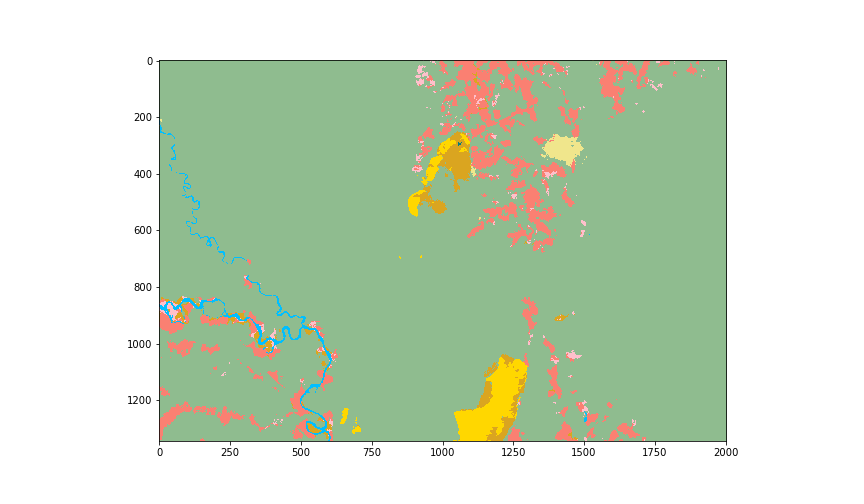

Labels after correction:


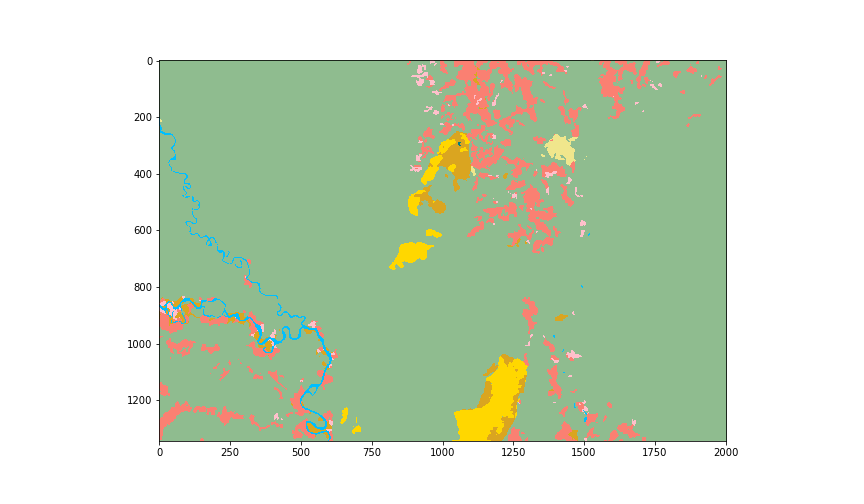

                             precision    recall  f1-score   support

   Urban and infrastructure      0.000     0.000     0.000         0
                Agriculture      0.730     0.729     0.730     16342
Arboreal and forestry crops      0.617     0.695     0.653       118
                    Pasture      0.940     0.903     0.921    171441
                 Vegetation      0.893     0.854     0.873     40663
                     Forest      0.985     0.994     0.989   2375951
                    Savanna      0.973     0.802     0.879     54037
  Sand, rocks and bare land      0.000     0.000     0.000         0
                      Swamp      0.000     0.000     0.000         0
                      Water      0.856     0.845     0.851     19764
           Seasonal savanna      0.729     0.974     0.834      7806
 Seasonally flooded savanna      0.000     0.000     0.000         0

                  micro avg      0.977     0.979     0.978   2686122
                  macro avg     

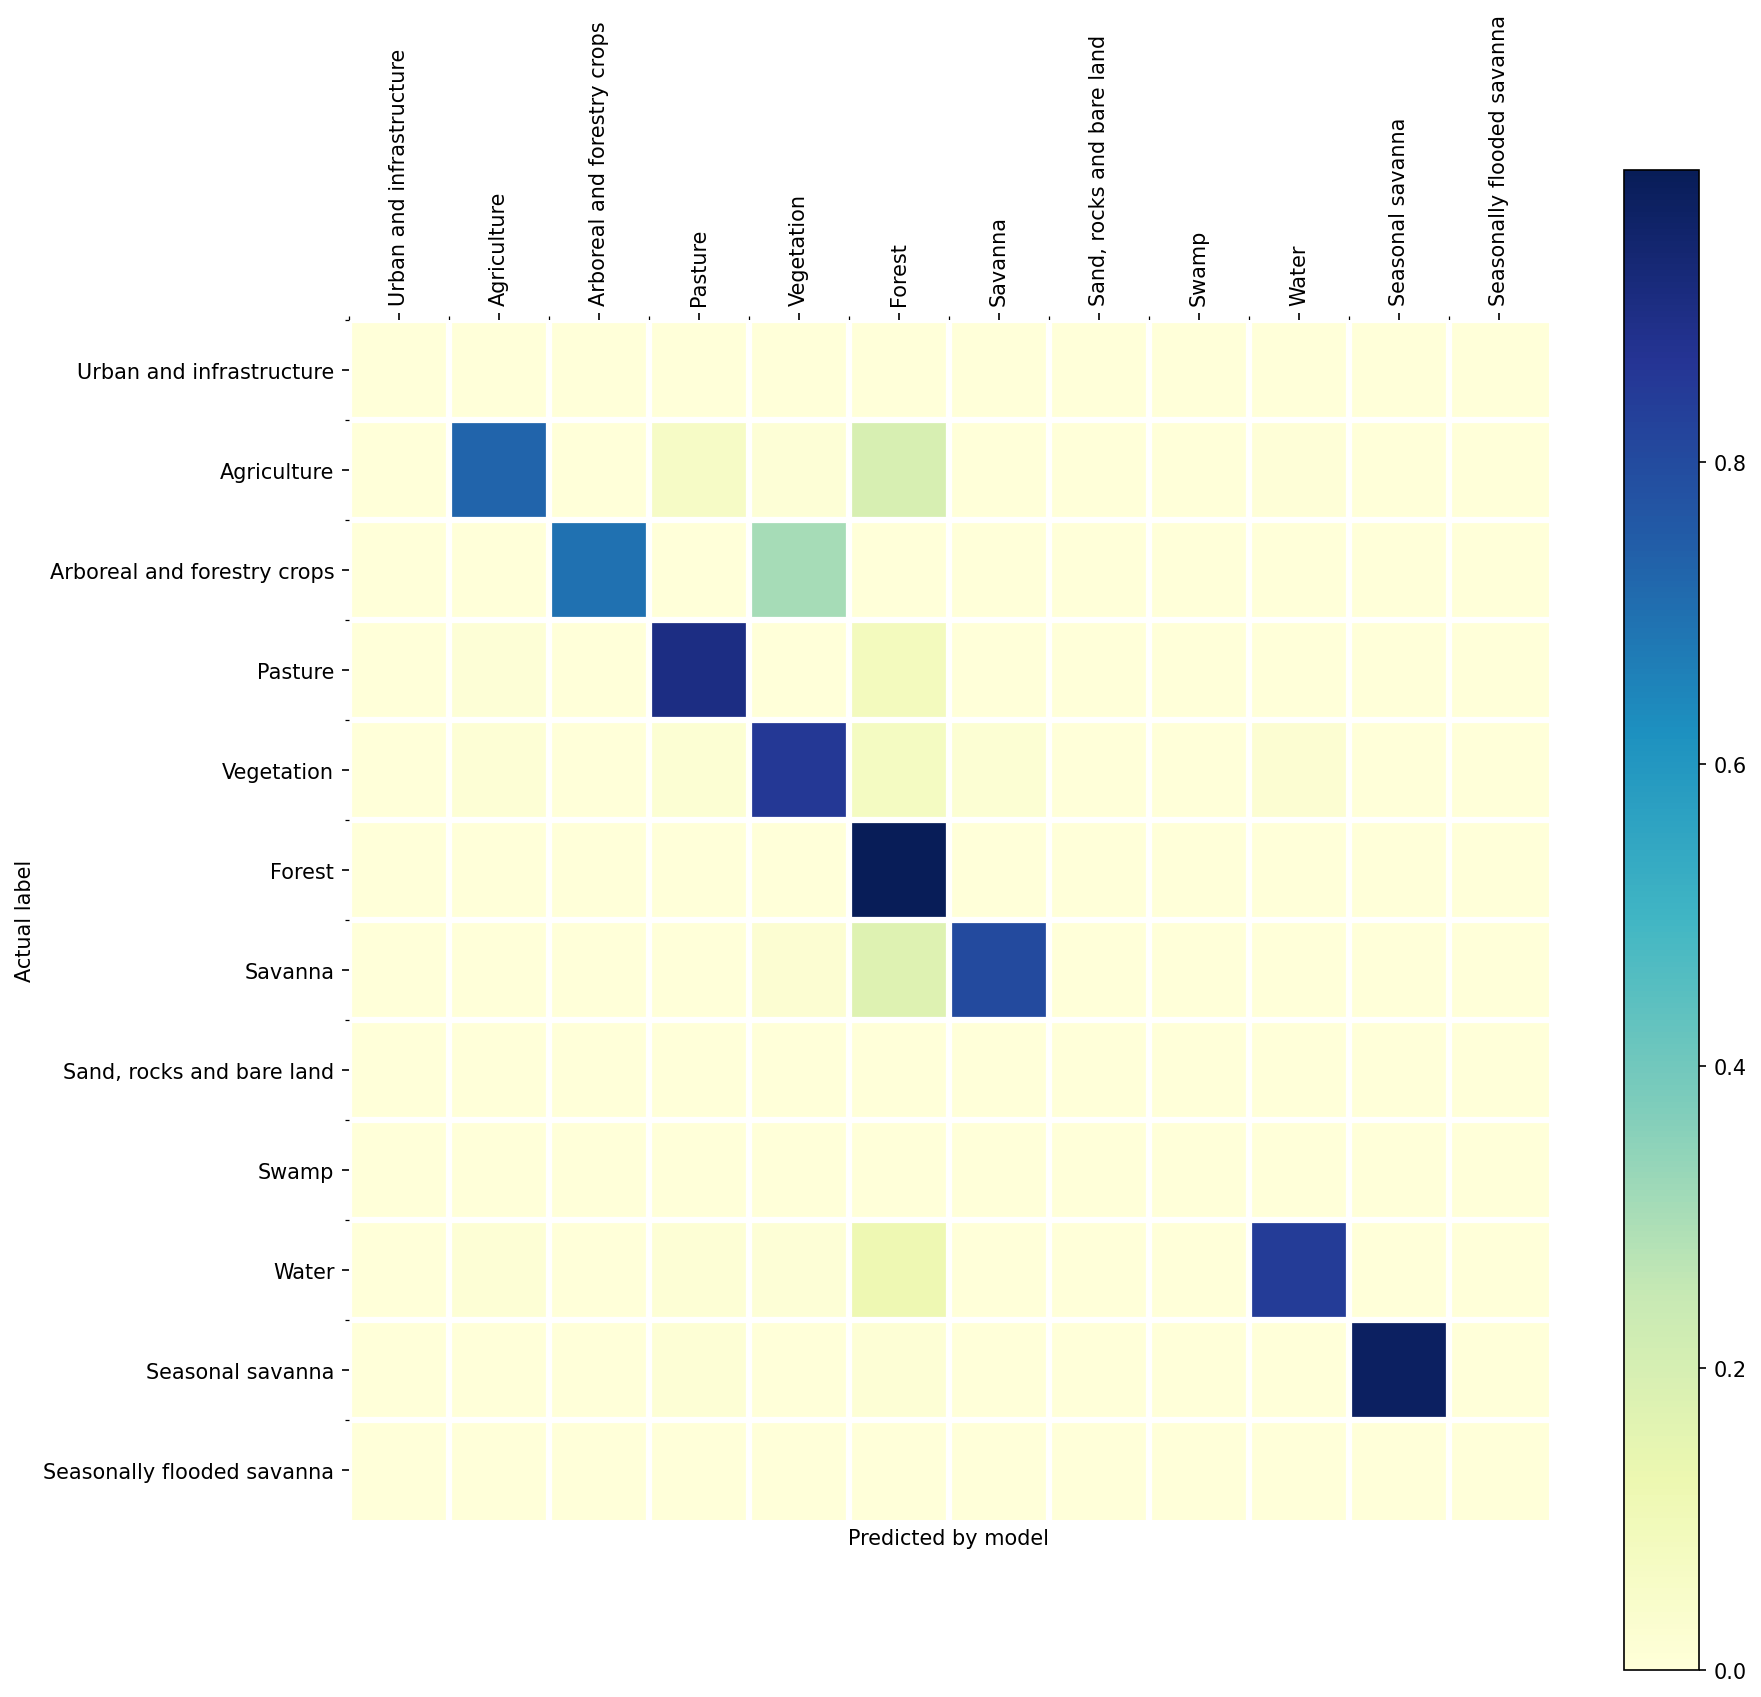

-------------------------------------------------------------------------------


Evaluating window_10
Model output:


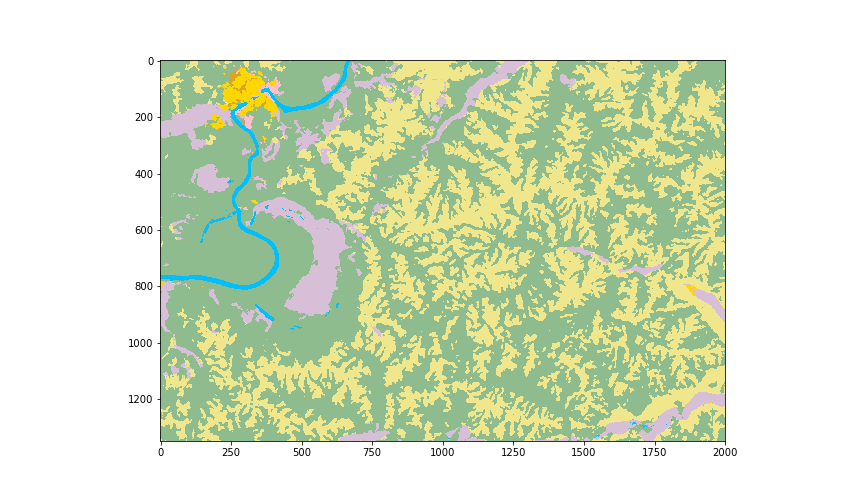

Labels after correction:


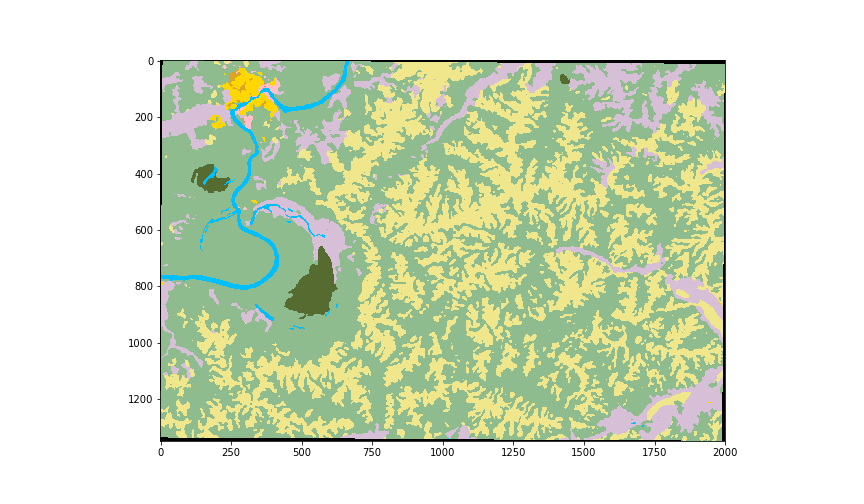

                             precision    recall  f1-score   support

   Urban and infrastructure      0.000     0.000     0.000         0
                Agriculture      0.868     0.890     0.879      4509
Arboreal and forestry crops      0.000     0.000     0.000         0
                    Pasture      0.371     0.754     0.497       171
                 Vegetation      0.804     0.893     0.846      2388
                     Forest      0.960     0.974     0.967   1525497
                    Savanna      0.828     0.939     0.880     17500
  Sand, rocks and bare land      0.000     0.000     0.000         0
                      Swamp      0.000     0.000     0.000     33090
                      Water      0.943     0.848     0.893     31522
           Seasonal savanna      0.830     0.959     0.890    790304
 Seasonally flooded savanna      0.729     0.524     0.610    251664

                  micro avg      0.899     0.913     0.906   2656645
                  macro avg     

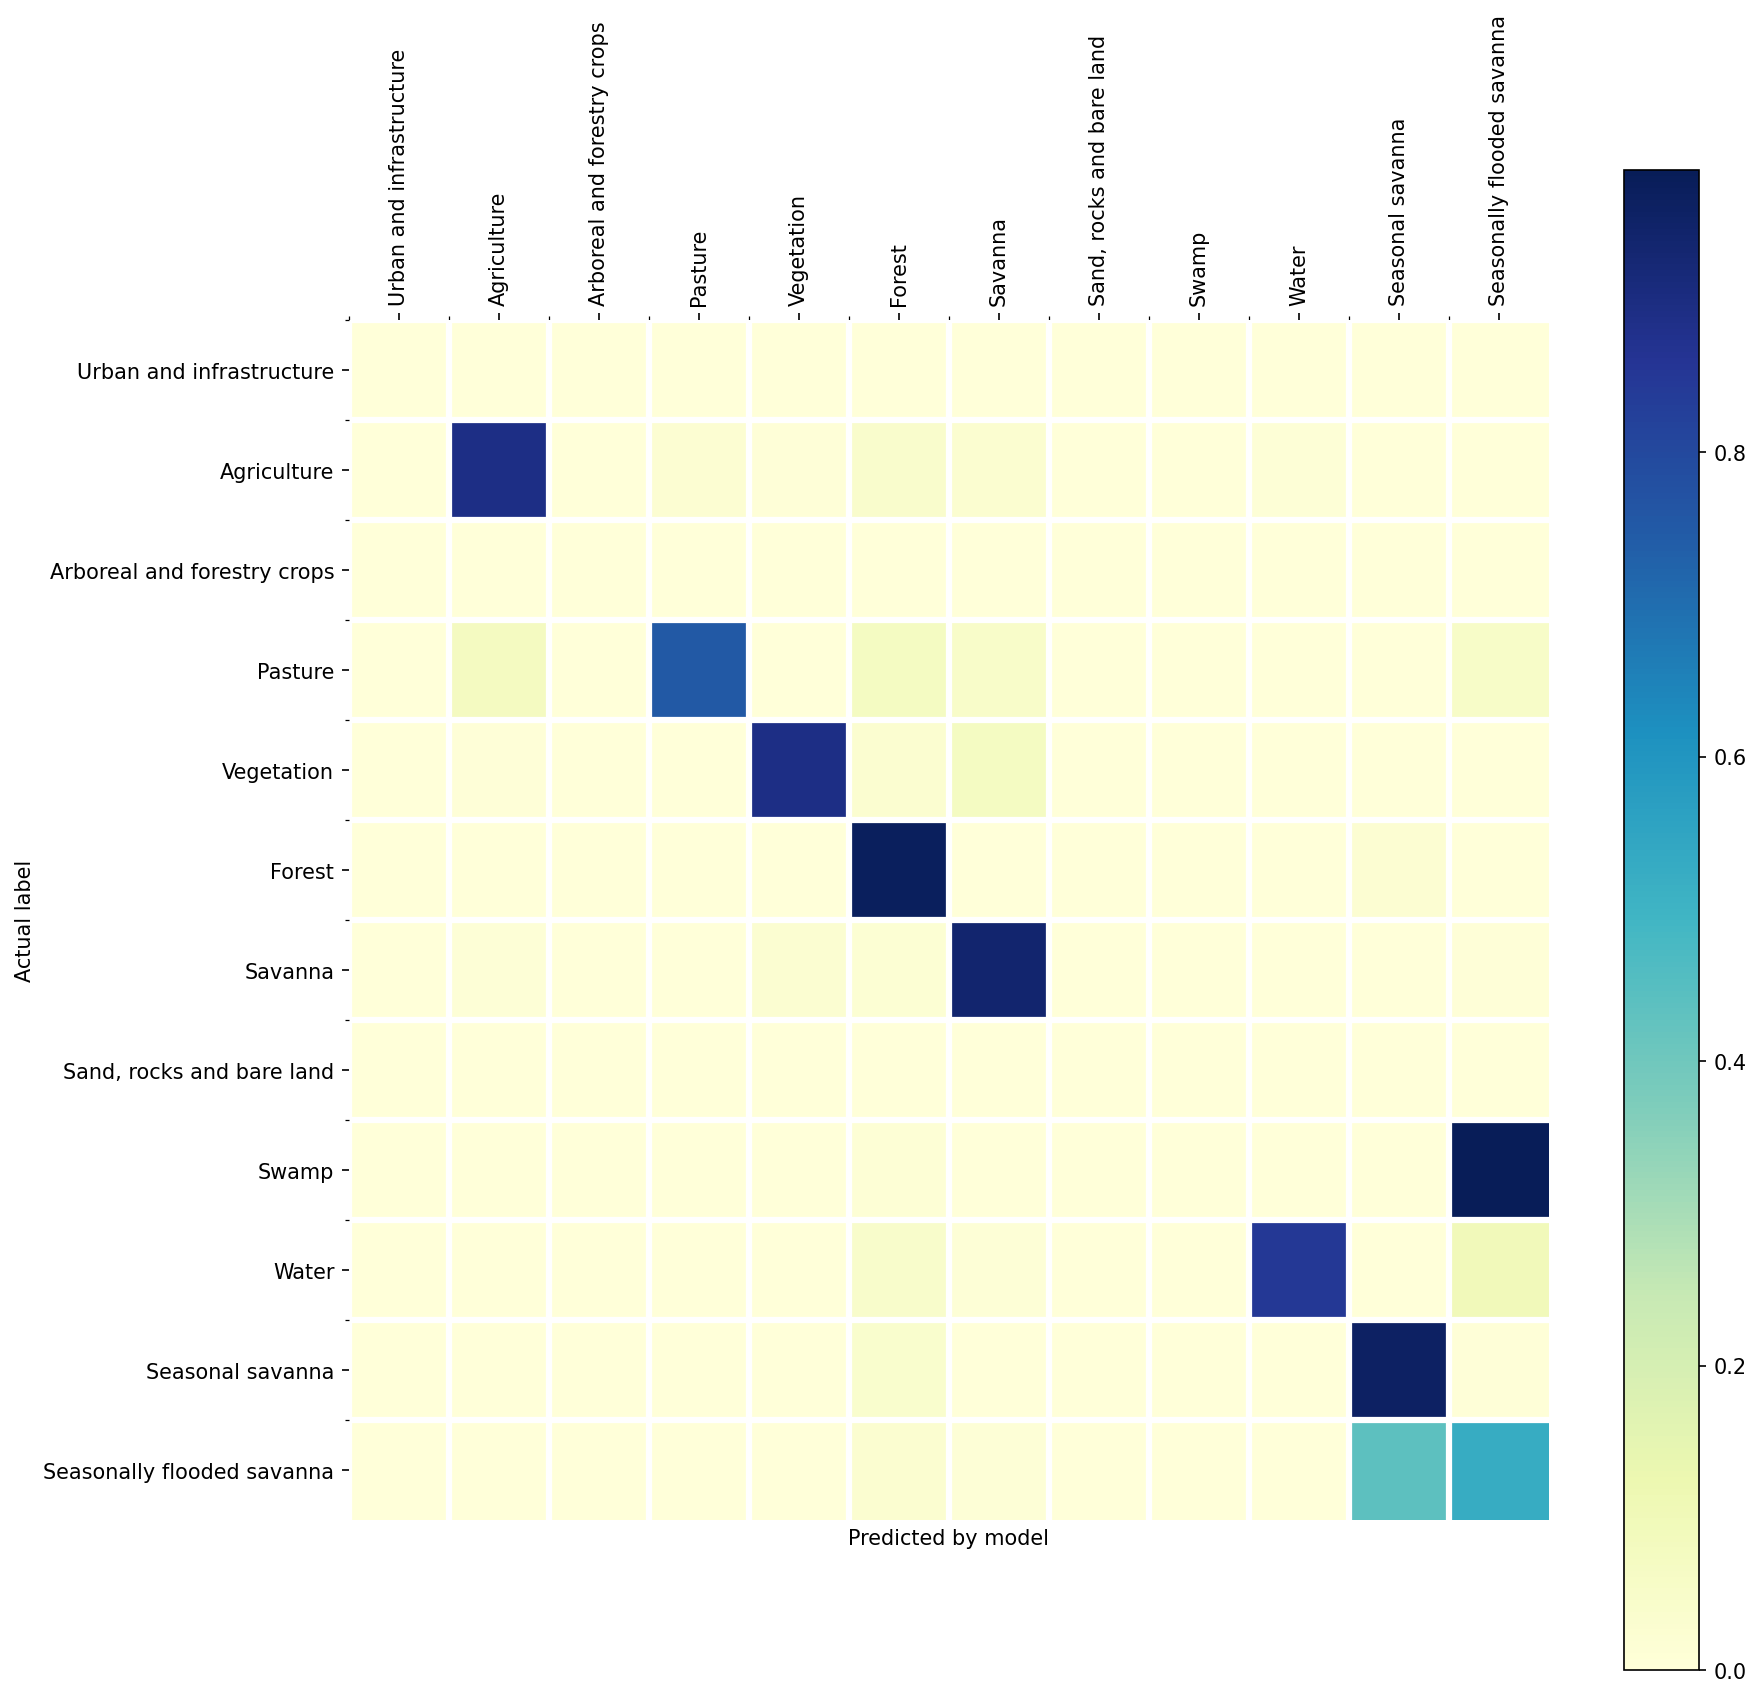

-------------------------------------------------------------------------------


Evaluating window_13
Model output:


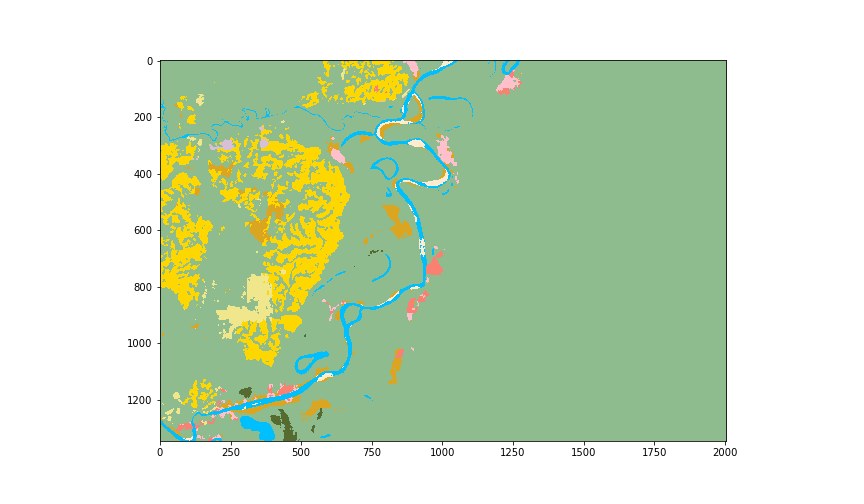

Labels after correction:


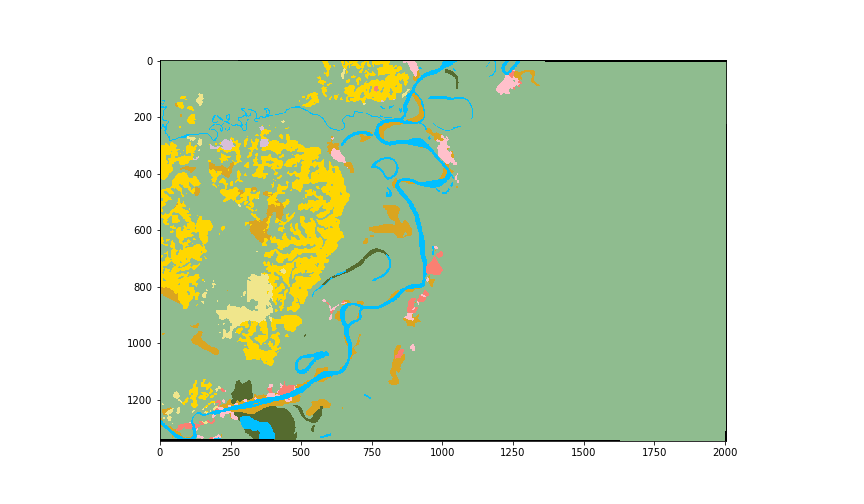

                             precision    recall  f1-score   support

   Urban and infrastructure      0.000     0.000     0.000         0
                Agriculture      0.896     0.854     0.875     15462
Arboreal and forestry crops      0.000     0.000     0.000         0
                    Pasture      0.852     0.930     0.889     11022
                 Vegetation      0.905     0.658     0.762     56241
                     Forest      0.970     0.993     0.981   2283609
                    Savanna      0.942     0.952     0.947    191594
  Sand, rocks and bare land      0.000     0.000     0.000         0
                      Swamp      0.951     0.268     0.418     24030
                      Water      0.920     0.787     0.848     66739
           Seasonal savanna      0.923     0.941     0.932     24502
 Seasonally flooded savanna      0.894     0.926     0.910      2888

                  micro avg      0.961     0.969     0.965   2676087
                  macro avg     

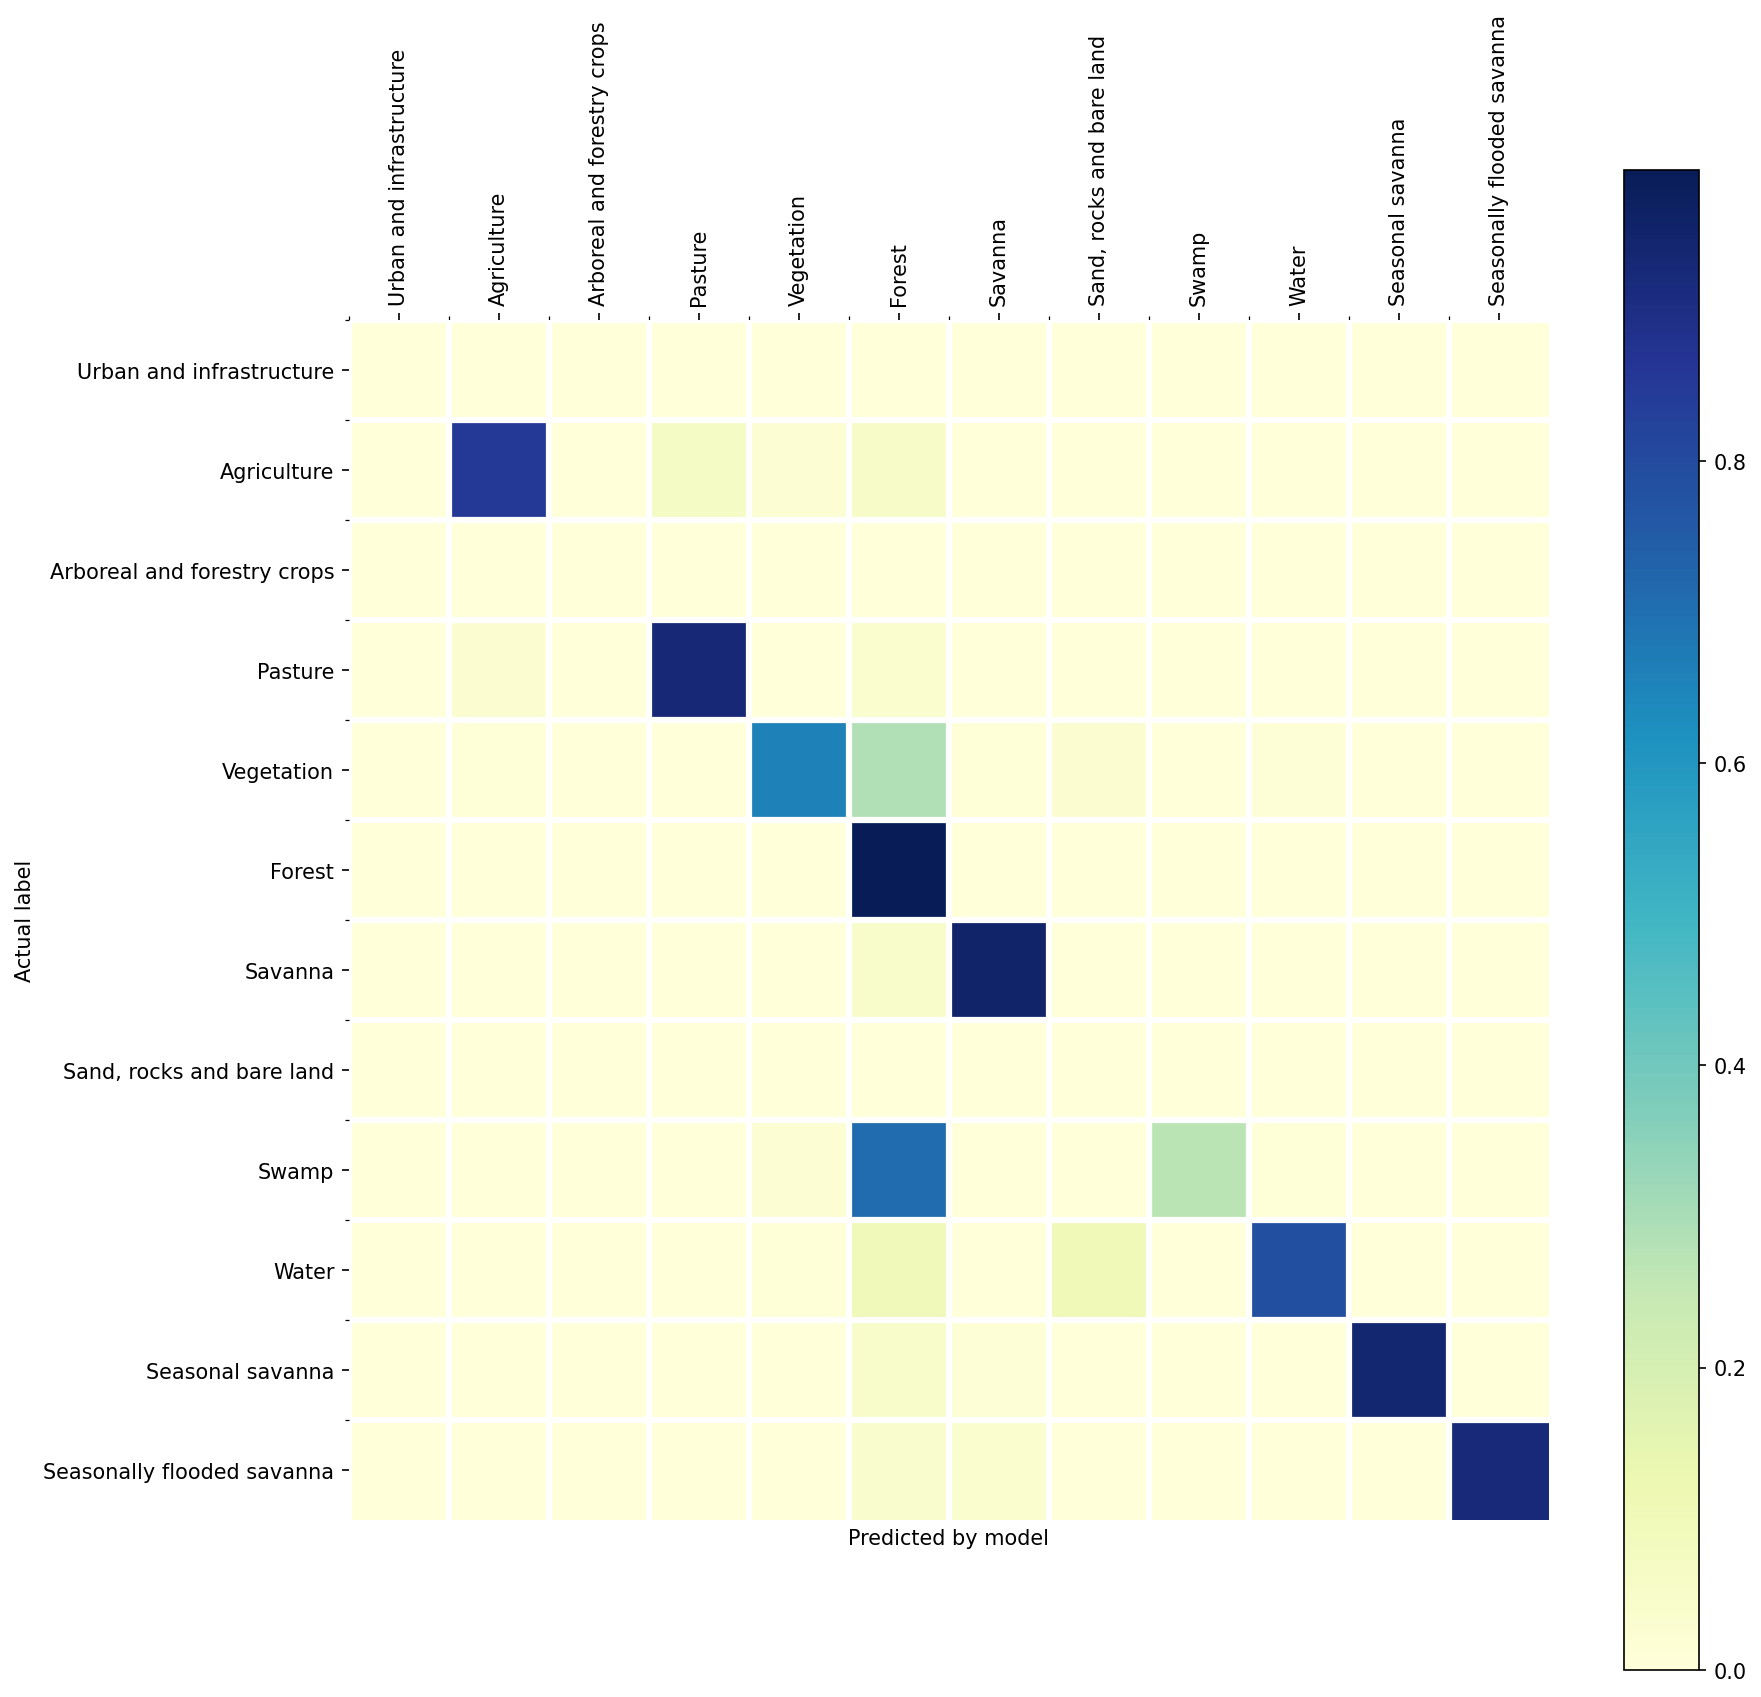

-------------------------------------------------------------------------------


Overall report:
                             precision    recall  f1-score   support

   Urban and infrastructure      0.653     0.691     0.671     19378
                Agriculture      0.796     0.925     0.856   1019772
Arboreal and forestry crops      0.894     0.900     0.897    180894
                    Pasture      0.904     0.596     0.718   2946508
                 Vegetation      0.858     0.551     0.671    334842
                     Forest      0.963     0.969     0.966   8393553
                    Savanna      0.920     0.919     0.919    266805
  Sand, rocks and bare land      0.110     0.753     0.193      2565
                      Swamp      0.904     0.120     0.211     67099
                      Water      0.869     0.833     0.851    413210
           Seasonal savanna      0.867     0.911     0.889   2928438
 Seasonally flooded savanna      0.602     0.885     0.717   2149860

   

In [41]:
for window_name, res in results.items():
    print(f'Evaluating {window_name}')
    
    print('Model output:')
    res['model_output_tile']
    
    print('Labels after correction:')
    res['label_tile']
    
    print(res['report'])
    
    fig = plot_confusion_matrix(res['cm_norm'], target_names)
    fig
    
    print('-------------------------------------------------------------------------------')
    print()
    print()

print('Overall report:')    
print(overall_report)

Overall confusion matrix:


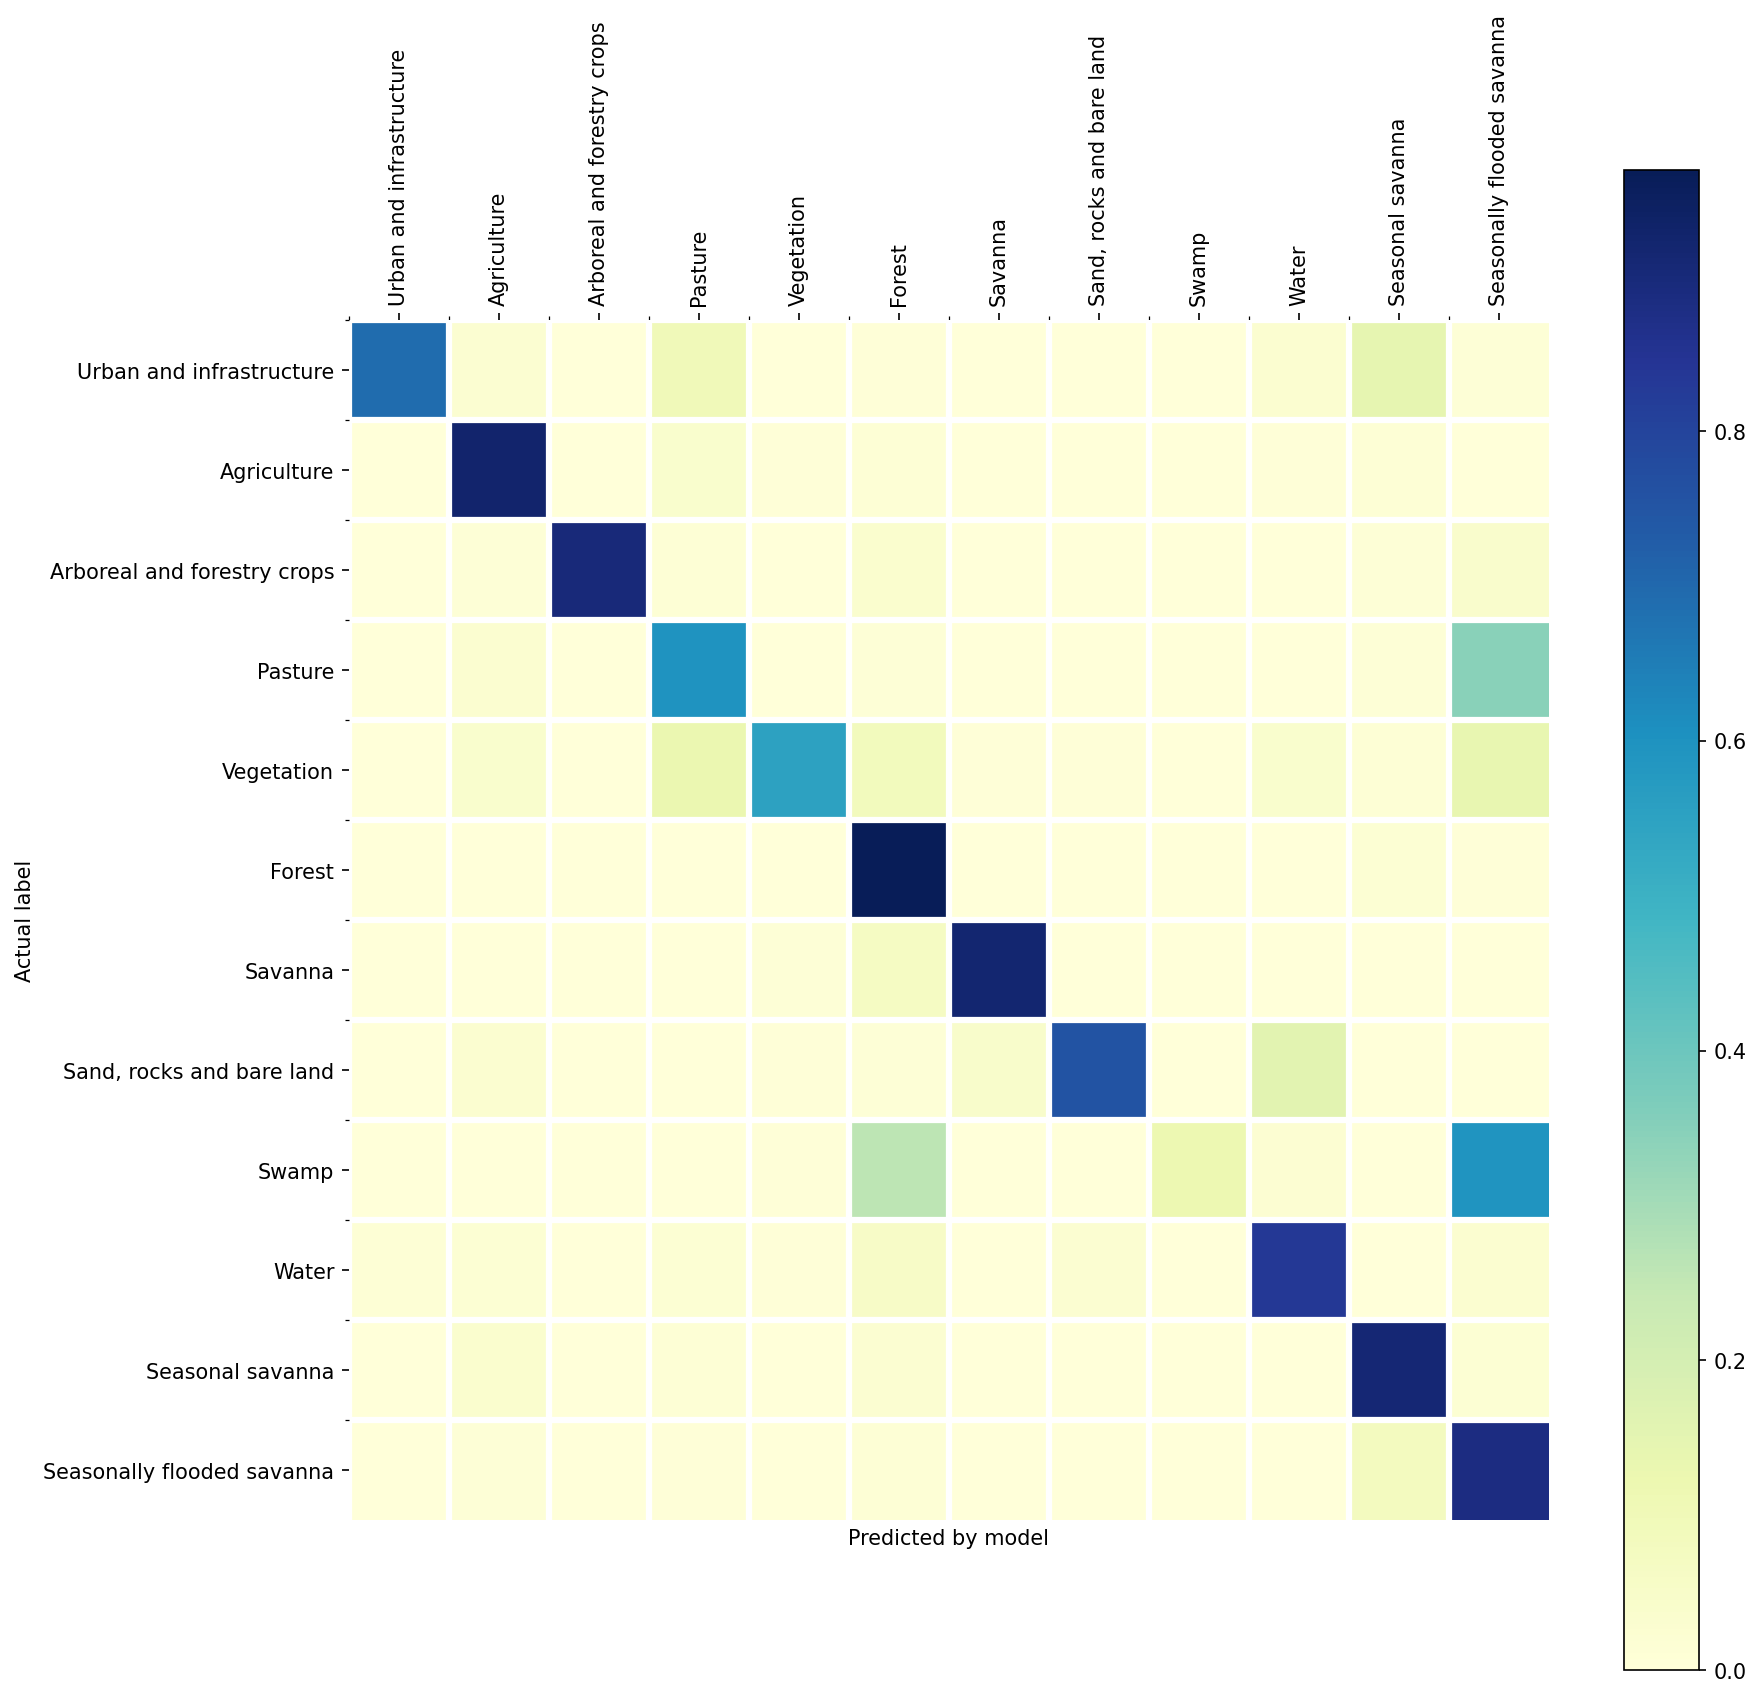

In [42]:
print('Overall confusion matrix:')

cm_norm = confusion_matrix(y_true, y_pred, labels=labels, normalize='true')

fig = plot_confusion_matrix(cm_norm, target_names)
fig

## Evaluating model outputs with majority filter radius 3 applied

In [10]:
results3, overall_report3 = evaluate_label_windows(model_outputs_filtered3_path)

100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


Calculating overall metrics...


In [11]:
print('Overall report for majority filter radius 3:') 
print(overall_report3)

Overall report for majority filter radius 3:
                             precision    recall  f1-score   support

   Urban and infrastructure       0.67      0.69      0.68     19378
                Agriculture       0.82      0.95      0.88   1019772
Arboreal and forestry crops       0.91      0.91      0.91    180894
                    Pasture       0.92      0.61      0.73   2946508
                 Vegetation       0.93      0.58      0.71    334842
                     Forest       0.97      0.97      0.97   8393553
                    Savanna       0.94      0.93      0.94    266805
  Sand, rocks and bare land       0.15      0.85      0.25      2565
                      Swamp       0.95      0.12      0.21     67099
                      Water       0.88      0.84      0.86    413210
           Seasonal savanna       0.87      0.92      0.90   2928438
 Seasonally flooded savanna       0.61      0.89      0.72   2149860

                  micro avg       0.87      0.88      0.

## Evaluating model outputs with majority filter radius 5 applied

In [12]:
results5, overall_report5 = evaluate_label_windows(model_outputs_filtered5_path)

100%|██████████| 7/7 [00:16<00:00,  2.36s/it]


Calculating overall metrics...


In [13]:
print('Overall report for majority filter radius 5:')  
print(overall_report5)

Overall report for majority filter radius 5:
                             precision    recall  f1-score   support

   Urban and infrastructure       0.68      0.69      0.68     19378
                Agriculture       0.81      0.94      0.87   1019772
Arboreal and forestry crops       0.91      0.91      0.91    180894
                    Pasture       0.91      0.60      0.73   2946508
                 Vegetation       0.93      0.55      0.70    334842
                     Forest       0.96      0.97      0.97   8393553
                    Savanna       0.94      0.92      0.93    266805
  Sand, rocks and bare land       0.14      0.75      0.24      2565
                      Swamp       0.96      0.12      0.21     67099
                      Water       0.87      0.81      0.84    413210
           Seasonal savanna       0.87      0.92      0.89   2928438
 Seasonally flooded savanna       0.60      0.89      0.72   2149860

                  micro avg       0.87      0.88      0.

## Evaluating model outputs with majority filter radius 7 applied

In [14]:
results7, overall_report7 = evaluate_label_windows(model_outputs_filtered7_path)

100%|██████████| 7/7 [00:16<00:00,  2.39s/it]


Calculating overall metrics...


In [15]:
print('Overall report for majority filter radius 7:')  
print(overall_report7)

Overall report for majority filter radius 7:
                             precision    recall  f1-score   support

   Urban and infrastructure       0.69      0.68      0.68     19378
                Agriculture       0.80      0.93      0.86   1019772
Arboreal and forestry crops       0.91      0.90      0.91    180894
                    Pasture       0.90      0.60      0.72   2946508
                 Vegetation       0.92      0.52      0.67    334842
                     Forest       0.95      0.96      0.96   8393553
                    Savanna       0.92      0.90      0.91    266805
  Sand, rocks and bare land       0.13      0.64      0.22      2565
                      Swamp       0.96      0.11      0.20     67099
                      Water       0.86      0.78      0.82    413210
           Seasonal savanna       0.85      0.91      0.88   2928438
 Seasonally flooded savanna       0.60      0.88      0.72   2149860

                  micro avg       0.86      0.87      0.